# Read in Packages

In [1]:
import os
import json
from glob import glob
import tempfile
import shutil
import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd #important
import cv2
import laspy #las open #https://laspy.readthedocs.io/en/latest/
from shapely.ops import transform
from shapely.geometry import Point,Polygon #convert las to gpd
import rioxarray
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import matplotlib.pyplot as plt
import rtree
#import pygeos

# Functions

In [2]:
def reproject_dems(initial_dem_dir, final_dem_dir):
    """ Reproject DEMS
    Args: 
    initial_dem_dir(str): directory holding DEMS with original projection
    final_dem_dir(str): directory to hold reprojected imaes 
    """
    initial_dem_paths = glob(initial_dem_dir + "/*.tif")
    dst_crs = 'EPSG:4326'
    for initial_dem_path in initial_dem_paths: #get the bounding box polygons
        dem_name = os.path.splitext(os.path.basename(initial_dem_path))[0]
        with rasterio.open(initial_dem_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({'crs': dst_crs,
                            'transform': transform,
                            'width': width,
                            'height': height })
            with rasterio.open(os.path.join(final_dem_dir, dem_name+"_EPSG4326.tif"), 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(source=rasterio.band(src, i),
                                destination=rasterio.band(dst, i),
                                src_transform=src.transform,
                                src_crs=src.crs,
                                dst_transform=transform,
                                dst_crs=dst_crs,
                                resampling=Resampling.nearest)

In [4]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [5]:
#get utm crs
def get_utm_crs_from_epsg_poly(poly):
    utm_crs_list = query_utm_crs_info(datum_name="WGS 84",
        area_of_interest=AreaOfInterest(west_lon_degree=poly.bounds[0],
                                        south_lat_degree=poly.bounds[1],
                                        east_lon_degree=poly.bounds[2],
                                        north_lat_degree=poly.bounds[3],),)
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    return(utm_crs)
def reproject_raster_mask_to_utm(poly,src, out_img, out_transform):
    """
    For a given raster, reproject to a UTM. 
    Args: 
    poly: the original polygon cooresponding to the raster 
    src: source raster 
    out_img: raster mask
    out_transform: corresponding out transform for the raster mask 
    """
    dirpath = tempfile.mkdtemp()
    temp_ = os.path.join(dirpath, "temp_.tif")
    
    #reproject to utm 
    utm_crs = get_utm_crs_from_epsg_poly(poly)
    kwargs = src.meta.copy() #dem is src in other code
    kwargs.update({'crs': utm_crs,
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform})

    #write the new raster
    out_img_utm = np.zeros((out_img.shape[1], out_img.shape[2]), dtype=np.uint8)
    with rasterio.open(temp_, 'w', **kwargs) as dst:
        reproject(source=out_img,
                    destination=out_img_utm,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_crs=utm_crs,
                    resampling=Resampling.nearest)
    #delete temp file
    shutil.rmtree(dirpath)
    return(out_img_utm)

In [6]:
def average_bare_earth_elevation_for_tanks(gdf, dem_paths):    
    """ Calculate the diameter of a given bounding bbox for imagery of a given resolution
    Arg:
    bbox(list): a list of the (xmin, ymin, xmax, ymax) coordinates for box 
    resolution(float): the (gsd) resolution of the imagery
    Returns:
    (diameter): the diameter of the bbox of interest
    """
    #identify inundation bounds                               
    geometry = []
    dem_names = []
    for dem_path in dem_paths: #get the bounding box polygons
        dem_name = os.path.basename(dem_path)
        dem_names.append(dem_name)
        dem = rasterio.open(dem_path)
        min_lon, min_lat, max_lon, max_lat = dem.bounds
        geometry.append(Polygon([(min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat)]))
    #make dataframe of inundation map bounds
    dem_bounds = gpd.GeoDataFrame({'name': dem_name,'geometry': geometry})

    #create dictionary for average bare earth elevation values for each tank
    average_bare_earth_elevation = np.array([-99999] *len(gdf))

    #get average bare earth elevation values values
    for tank_index, tank_poly in enumerate(gdf["geometry"]): #iterate over the tank polygons
        for dem_index, dem_poly in enumerate(dem_bounds["geometry"]): #iterate over the dem polygons
            if dem_poly.contains(tank_poly): #identify whether the bbox is inside of the dem map
                #make a geodataframe for each tank polygon that is contained within the dem
                geo = gpd.GeoDataFrame({'geometry': tank_poly}, index=[0], crs=gdf.crs)
                coords = getFeatures(geo) 
                dem = rasterio.open(dem_paths[dem_index])
                out_img, out_transform = rasterio.mask.mask(dataset=dem, shapes=coords, crop = True)
                #average_bare_earth_elevation[tank_index] = np.average(out_img)
                #average to reprojected raster
                out_img_utm = reproject_raster_mask_to_utm(tank_poly, dem, out_img, out_transform)
                average_bare_earth_elevation[tank_index] = np.average(out_img_utm)
    #add inundation values to tank database 
    gdf["average_bare_earth_elevation"] = average_bare_earth_elevation

    return(gdf)

# Read in tile data

In [7]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk"
tank_data = gpd.read_file(os.path.join(parent_directory,"complete_dataset/tile_level_annotations/tile_level_annotations.geojson"))
tank_data = tank_data.to_crs('EPSG:4326')
image_characteristics = pd.read_csv("C:/Users/rapiduser/cred/AST_dataset/data_download_and_preprocessing/image_characteristics.csv")
tile_characteristics = pd.read_csv("C:/Users/rapiduser/cred/AST_dataset/data_download_and_preprocessing/tile_characteristics.csv")

# Process lidar data 

Note on reading in compressed data. 
A backend to decompress laz files is required. A backend can be install in the terminal as [`pip install laspy[lazrs,laszip]`](https://laspy.readthedocs.io/en/latest/installation.html).
#https://stackoverflow.com/questions/71641718/what-is-the-laspy-error-when-reading-laz-files
#https://laspy.readthedocs.io/en/latest/api/laspy.compression.html#laspy.compression.LazBackend #backend compression info

###### Alternative methods for accessing Lidar data
[PDAL](https://pdal.io/pipeline.html#pipelines)
[Pylas](https://towardsdatascience.com/a-gis-pipeline-for-lidar-point-cloud-feature-extraction-8cd1c686468a)

###### Lidar Coorinate System, WTK, References
https://docs.geotools.org/stable/javadocs/org/opengis/referencing/doc-files/WKT.html
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/epsg-proj4-coordinate-reference-system-formats-python/

###### Height Estimation
https://github.com/Abuton/lidarDataExtractor/tree/main/notebook_walkthrough 
https://github.com/tahirdme/LIDAR-Height-Extractor/blob/master/Height%20Extractor%20Code.ipynb
https://desktop.arcgis.com/en/arcmap/latest/extensions/3d-analyst/3d-buildings-obtaining-elevation-information-for-building-footprints.htm
https://desktop.arcgis.com/en/arcmap/latest/manage-data/las-dataset/lidar-solutions-creating-raster-dems-and-dsms-from-large-lidar-point-collections.htm
https://medium.com/one-concern/estimating-building-heights-using-lidar-data-b2f979266c3b
https://hal.inria.fr/hal-01348265/document

###### Visualization
https://medium.com/spatial-data-science/an-easy-way-to-work-and-visualize-lidar-data-in-python-eed0e028996c

###### Pull data from USGS
https://apps.nationalmap.gov/tnmaccess/#/
https://apps.nationalmap.gov/help/documents/TNMAccessAPIDocumentation/TNMAccessAPIDocumentation.pdf
https://github.com/cheginit/py3dep

In [8]:
#1. Read in lidar data using laspy 
#lidar_dir = os.path.join(parent_directory, "lidar")
#lidar_paths = glob(lidar_dir + "/*.laz")
las = laspy.read(lidar_paths[0])
las_crs = pyproj.CRS.from_user_input(las.header.vlrs.get("WktCoordinateSystemVlr")[0].string) #get crs
#list(las.header.point_format.dimension_names)
#las.header.point_count
#set(list(las.classification))

In [9]:
#1. Read in lidar data using laspy 
#lidar_dir = os.path.join(parent_directory, "lidar")
#lidar_paths = glob(lidar_dir + "/*.laz")
las = laspy.read(lidar_paths[0])
las_crs = pyproj.CRS.from_user_input(las.header.vlrs.get("WktCoordinateSystemVlr")[0].string) #get crs
#list(las.header.point_format.dimension_names)
#las.header.point_count
#set(list(las.classification))
#2. CONVERTING LAS TO PANDAS#
#Import LAS into numpy array (X=raw integer value; x=scaled float value)
lidar_points = np.array((las.x, las.y, las.z,las.intensity)).transpose()
#Transform to pandas DataFrame
lidar_df = pd.DataFrame(lidar_points, columns = ['X coordinate', 'Y coordinate', 'Z coordinate', 'Intensity'])
# transform into the geographic coordinate system
Geometry = [Point(xy) for xy in zip(las.x,las.y)] #make x+y coordinates into points
EPSG4326 = pyproj.CRS('EPSG:4326')
project = pyproj.Transformer.from_proj(las_crs, EPSG4326).transform
Geometry_gcs = [transform(project, las_point) for las_point in Geometry]
#Transform to geopandas GeoDataFrame
lidar = gpd.GeoDataFrame(lidar_df, crs =EPSG4326, geometry=Geometry_gcs) #set correct spatial reference
lidar = lidar.to_crs('EPSG:4326')
#3. Get the extent of the Lidar data 
miny, minx, maxy, maxx = lidar["geometry"].total_bounds
lidar_extent = Polygon([(minx,miny), (minx,maxy), (maxx,maxy), (maxx,miny)])
#4. Subset the tank dataset to the lidar data
index = []
for tank_index, tank_poly in tqdm.tqdm(enumerate(tank_data["geometry"])): #iterate over the tank polygons
    if lidar_extent.contains(tank_poly): #identify whether the tank bbox is inside of the state polygon
        index.append(tank_index) #add state name for each tank to list 
tank_data_in_lidar_extent = tank_data.iloc[index]
#Get the LP corresponding with the tank dataset
tank_data_w_lpc = gpd.sjoin(tank_data_in_lidar_extent,lidar, how='left', predicate='contains')
tank_data_w_lpc = tank_data_w_lpc.dropna(subset=['Z coordinate'])


ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

In [ ]:
https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html
https://geopandas.org/en/stable/gallery/spatial_joins.html

# Digital elevation model (DEM)


- produced through the 3D Elevation Program (3DEP)
- The elevations in this DEM represent the topographic bare-earth surface. 
- USGS standard one-meter DEMs are produced exclusively from high resolution light detection and ranging (lidar) source data of one-meter or higher resolution. 
- One-meter DEM surfaces are seamless within collection projects, but, not necessarily seamless across projects. 
#### Spatial reference:
- the spatial reference for one-meter DEM tiles within the conterminous United States (CONUS) is Universal Transverse Mercator (UTM) in units of meters, and in conformance with the North American Datum of 1983 (NAD83). 
- All bare earth elevation values are in meters and are referenced to the North American Vertical Datum of 1988 (NAVD88). 
- Each tile is distributed in the UTM Zone in which it lies. If a tile crosses two UTM zones, it is delivered in both zones. 
#### Resolution
- The one-meter DEM is the highest resolution standard DEM offered in the 3DEP product suite. 
- Other 3DEP products are nationally seamless DEMs in resolutions of 1/3, 1, and 2 arc seconds. These seamless DEMs were referred to as the National Elevation Dataset (NED) from about 2000 through 2015 at which time they became the seamless DEM layers under the 3DEP program and lost the NED branding.

[Overview of USGS elevation products](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services)
[Explanations of the differences between DEM, DTM, and DSM](https://up42.com/blog/tech/everything-you-need-to-know-about-digital-elevation-models-dem-digital#:~:text=DTMs%20are%20often%20confused%20with,development%20of%20the%20geodesic%20surface)
https://www.usgs.gov/faqs/what-difference-between-lidar-data-and-digital-elevation-model-dem
https://support.plexearth.com/hc/en-us/articles/4642425453201-Elevation-Modeling-the-differences-between-DTM-DSM-DEM#:~:text=The%20main%20difference%20between%20the,features%20on%20the%20earth's%20surface.s

In [59]:
#outlier values within a bounding box

In [8]:
#reproject_dems(os.path.join(parent_directory, "DEM/UTM"), os.path.join(parent_directory, "DEM/EPSG4326"))
dem_paths = glob(os.path.join(parent_directory, "DEM/EPSG4326")+ "/*.tif")

In [56]:
gdf = average_bare_earth_elevation_for_tanks(tank_data, dem_paths)

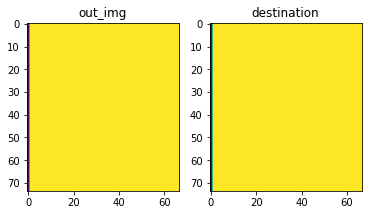

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.set_title('out_img')
ax1.imshow(out_img[0])
ax2.set_title('destination')
ax2.imshow(destination)
plt.show() 